In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID_1.csv'
df = pd.read_csv(data_path)

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Define the mapping for the selected categories
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}

# Map the 'Patient Race' column to the corresponding strings
df['Patient Race'] = df['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN
df_cleaned = df.dropna(subset=['Patient Race'])

# Ensure unique patients
unique_patients = df_cleaned.drop_duplicates(subset=['Subject ID'])

# Sample a maximum number of images per patient (1 image per unique patient)
sampled_df = unique_patients.sample(n=1000, random_state=42)

In [4]:
print("Shape of the cleaned DataFrame:", sampled_df.shape)

Shape of the cleaned DataFrame: (1000, 21)


In [5]:
# Convert the 'Patient Race' to integer labels
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Map the categorical race labels to numerical values
sampled_df['Race_Label'] = sampled_df['Patient Race'].map(label_mapping)

# Split the data into training and validation sets (stratified by race)
X_train, X_val, y_train, y_val = train_test_split(
    sampled_df['File Location'],  # File paths to the DICOM images
    sampled_df['Race_Label'],     # Race labels as integers
    test_size=0.2, 
    stratify=sampled_df['Race_Label'], 
    random_state=42
)

Class distribution after cleaning:
White                                        921
Black or African-American                     52
Asian                                         17
Native Hawaiian or Other Pacific Islander      7
American Indian or Alaskan Native              3
Name: Patient Race, dtype: int64


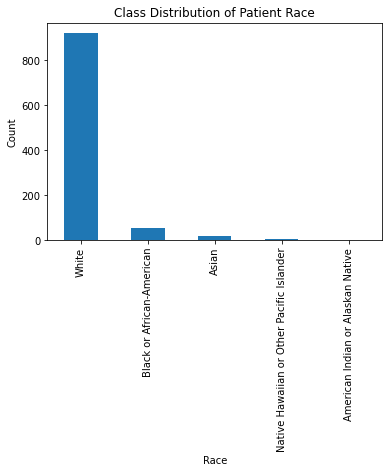

In [6]:
import matplotlib.pyplot as plt
# Check class distribution
print("Class distribution after cleaning:")
print(sampled_df['Patient Race'].value_counts())

# Plot class distribution
sampled_df['Patient Race'].value_counts().plot(kind='bar', title="Class Distribution of Patient Race", xlabel="Race", ylabel="Count")
plt.show()


In [7]:
current_path = os.getcwd()
print(current_path)

u:\GitHub\AI-ethnicity-med-image


In [8]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [9]:
# Preprocess images for model input
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    
    # Ensure only one image per patient (process the first DICOM file found)
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file only
            dicom_path = os.path.join(dicom_folder, dicom_file)
            ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
            img_array = ds.pixel_array  # Extract pixel array

            # Normalize the image
            img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

            # Resize the image
            img = Image.fromarray(img_array)  # Convert to PIL image
            img = img.resize((224, 224))  # Resize to 224x224 pixels
            img_array_resized = np.array(img)  # Convert back to numpy array

            # Convert grayscale image to 3-channel RGB by repeating the single channel 3 times
            img_array_rgb = np.stack([img_array_resized] * 3, axis=-1)

            image_data.append(img_array_rgb)
            processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [10]:
# Preprocess images for training and validation sets (ensure 1 image per patient)
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

In [11]:
# Check the number of images
num_train_images = X_train_images.shape[0]
num_val_images = X_val_images.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")

Number of training images: 800
Number of validation images: 200
Number of training labels: 800
Number of validation labels: 200


###  Fine-tune a pre-trained EfficientNetB0 model for a new multi-class classification task

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [13]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization

num_classes = 5
output = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

In [14]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the preprocessed images
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=10, 
                    batch_size=32)

# Save the model
model.save('ethnicity_classification_model.h5')

Epoch 1/10
25/25 [==============================] - 63s 2s/step - loss: 10.6197 - accuracy: 0.8462 - val_loss: 8.3874 - val_accuracy: 0.9200
Epoch 2/10
25/25 [==============================] - 54s 2s/step - loss: 5.4636 - accuracy: 0.8650 - val_loss: 4.8007 - val_accuracy: 0.9200
Epoch 3/10
25/25 [==============================] - 51s 2s/step - loss: 3.2654 - accuracy: 0.8512 - val_loss: 2.7726 - val_accuracy: 0.9050
Epoch 4/10
25/25 [==============================] - 54s 2s/step - loss: 1.5363 - accuracy: 0.8763 - val_loss: 1.5105 - val_accuracy: 0.8900
Epoch 5/10
25/25 [==============================] - 58s 2s/step - loss: 0.7265 - accuracy: 0.9000 - val_loss: 0.6314 - val_accuracy: 0.9200
Epoch 6/10
25/25 [==============================] - 58s 2s/step - loss: 0.4843 - accuracy: 0.9050 - val_loss: 0.6409 - val_accuracy: 0.9200
Epoch 7/10
25/25 [==============================] - 61s 2s/step - loss: 0.4305 - accuracy: 0.9175 - val_loss: 0.4884 - val_accuracy: 0.9150
Epoch 8/10
25/25 [=

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns

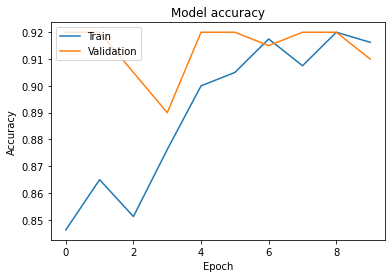

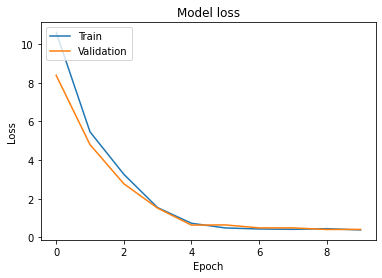

In [16]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# Make predictions on the validation set
y_pred = model.predict(X_val_images)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)


Accuracy: 0.9100


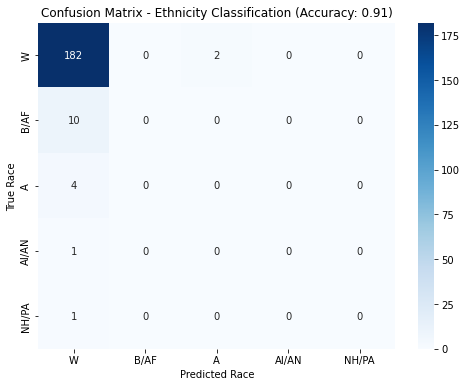

In [18]:
# Create a confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

cma = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define race labels
race_labels = ['W', 'B/AF', 'A', 'AI/AN', 'NH/PA']

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=race_labels, yticklabels=race_labels)
plt.xlabel('Predicted Race')
plt.ylabel('True Race')
plt.title(f'Confusion Matrix - Ethnicity Classification (Accuracy: {accuracy:.2f})')
plt.show()


In [23]:
# Calculate balanced accuracy
bal_accuracy = balanced_accuracy_score(y_val_labels, y_pred_labels)
print(f"Balanced Accuracy: {bal_accuracy:.2f}")

Balanced Accuracy: 0.20


In [19]:
# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_mapping.keys(), zero_division=1))

Classification Report:
                                           precision    recall  f1-score   support

                                    White       0.92      0.99      0.95       184
                Black or African-American       1.00      0.00      0.00        10
                                    Asian       0.00      0.00      0.00         4
        American Indian or Alaskan Native       1.00      0.00      0.00         1
Native Hawaiian or Other Pacific Islander       1.00      0.00      0.00         1

                                 accuracy                           0.91       200
                                macro avg       0.78      0.20      0.19       200
                             weighted avg       0.91      0.91      0.88       200

